## Homework2 Coding Part

### 4. Coding: VAE on MNIST

A Python notebook with the code to be completed is provided. Please complete it using the following intructions. This problem is adapted from the pset1 of [Course 6.S978 Deep Generative Models](https://mit-6s978.github.io/schedule.html) given by Professor Kaiming He at MIT.

VAEs are trained by maximizing the Evidence Lower Bound (ELBO) on the marginal log-likelihood:
$$\log p(x) \geq \mathbb{E}_{q(z|x)}\left[\log\frac{p(x, z)}{q(z|x)}\right] = \mathrm{ELBO},$$

where $x$ is the data (binary images for MNIST) and $z$ is the latent code.

(a) Give a detailed mathematical proof of the ELBO starting from the marginal log-likelihood $\log p(x)$. (2 Points)

(b) Complete the implementation of the  ``self.encoder`` and ``self.decoder`` in the ``VAE()`` model. (2 Points)

(c) Implement the reparameterization trick in the ``reparameterize()`` function. In this assignment, we only sample one latent code $z_{i}$ for each $x_i$. (1 Points)

(d) In practice, the above expectation in ELBO is estimated using Monte Carlo sampling, yielding the generic Stoachastic Gradient Variational Bayes (SGVB) estimator,
$$\mathrm{ELBO} \approx \sum_{i} \left[\log p(x_i|z_{i}) + \log p(z_{i}) - \log q(z_{i}|x_i)\right],$$
where $z_{i}$ is sampled from $ q(z|x_i) = \mathcal{N}(z;\mu_i, \sigma^2_i \mathbf{I})$.

Finalize the SGVB estimator by completing the ``log_normal_pdf()`` function, which computes the log probability for a normal distribution given its mean and variance. (1 Points)

(e) In many cases, Monte Carlo sampling is not necessary to estimate all the terms of ELBO, as some terms can be integrated analytically. In particular, when both $q(z|x)=\mathcal{N}(z;\mu(x),\mathrm{diag}(\sigma^2(x)))$ and $p(z)=\mathcal{N}(z;0,I)$ are Gaussian distributions, the ELBO can be decomposed into an analytical KL divergence plus the expected reconstruction error:
$$\mathrm{ELBO} \approx -D_{KL}(q(z|x) \| p(z)) + \sum_{i} \log p(x_i|z_{i}) = \\\frac{1}{2}\sum_{d}(1+\log((\sigma_d)^2) - (\mu_d)^2 - (\sigma_d)^2) + \sum_{i} \log p(x_i|z_{i})$$
where $d$ is the dimension of the latent space, and i is the indices of the data.

Run the verfirication code to check if the analytical KL divergence matches the Monte Carlo estimate. (2 Points)

(f) Using the above two losses, train two VAE models on the MNIST dataset (manual tuning of parameters such as epochs, hidden dims, lr, coeff may be necessary). Use the provided evaluation code to visualize the reconstruction results and the generated images (in 2D grid) for both models. (3 Points)

(g) Latent Interpolation: Encode two MNIST test images with different digit labels to obtain latent codes $z_1$ and $z_2$. Linearly interpolate between them using $z(\alpha) = (1-\alpha)z_1 + \alpha z_2$ for $\alpha\in\{0,0.1,\dots,1\}$, decode each interpolated code with your trained VAE decoder, and display the generated images in order. Briefly describe how the generated digits gradually transform from one class to the other along the interpolation. (2 Points)

The answer to the questions above are in $\texttt{hw2\_2025213446.pdf}$'s Problem 4 part.

### Code to Be Completed

#### Import Libraries and Functions

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### MNIST Data Loader

In [2]:
tensor_transform = transforms.ToTensor()

batch_size = 256
MNIST_dataset = datasets.MNIST(root = "./data", train = True, download = True, transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset, batch_size = batch_size, shuffle = True)

#### Training Function

In [3]:
from math import e
mse = torch.nn.MSELoss()

def loss_func(model, x, reg_func=None, coeff=1e-3):
    output = model(x)
    err = mse(output['imgs'], x)
    logpx_z = -1.0 * torch.sum(err)

    if reg_func is not None:
        reg = reg_func(output)
    else:
        reg = 0.0

    return -1.0 * torch.mean(logpx_z + coeff * reg)

def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses

#### Evaluation Function

In [4]:
def plot_latent_images(model, n, digit_size=28):
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def eval(model):
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
    with torch.no_grad():
      res = model(original_imgs.reshape(5, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

#### Model

In [5]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, decode_dim=-1, use_sigmoid=True):
        '''
        input_dim: The dimensionality of the input data.
        hidden_dims: A list of hidden dimensions for the layers of the encoder and decoder.
        decode_dim: (Optional) Specifies the dimensions to decode, if different from input_dim.
        '''
        super().__init__()
        # input_dim = 256
        # decode_dim = -1
        # hidden_dims = [128, 64, 36, 18, 18]
        self.z_size = hidden_dims[-1] // 2
        if decode_dim == -1:
            decode_dim = input_dim


        # encoder: 768 -> [128 -> 64 -> 36 -> 18 -> 18]
        encoder_layers = [torch.nn.Linear(input_dim, hidden_dims[0]), torch.nn.ReLU()]
        for i in range(len(hidden_dims) - 2):
            encoder_layers += [torch.nn.Linear(hidden_dims[i], hidden_dims[i+1]), torch.nn.ReLU()]
        encoder_layers += [torch.nn.Linear(hidden_dims[-2], hidden_dims[-1])]
        self.encoder = torch.nn.Sequential(*encoder_layers)


        # decoder: 9 -> [18 -> 18 -> 36 -> 64 -> 128] -> 768
        decoder_layers = [torch.nn.Linear(self.z_size, hidden_dims[-1]), torch.nn.ReLU()]
        for i in range(len(hidden_dims) - 1, 0, -1):
            decoder_layers += [torch.nn.Linear(hidden_dims[i], hidden_dims[i-1]), torch.nn.ReLU()]
        decoder_layers += [torch.nn.Linear(hidden_dims[0], decode_dim)]
        if use_sigmoid:
            decoder_layers += [torch.nn.Sigmoid()]
        self.decoder = torch.nn.Sequential(*decoder_layers)


    def encode(self, x):
        mean, logvar = torch.split(self.encoder(x), split_size_or_sections=[self.z_size, self.z_size], dim=-1)
        return mean, logvar

    def reparameterize(self, mean, logvar, n_samples_per_z=1):
        # the mean and logvar are (B, z_size), expanded at forward step
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + std * eps # (B * n_samples_per_z, z_size)
        return z


    def decode(self, z):
        probs = self.decoder(z)
        return probs

    def forward(self, x, n_samples_per_z=1):
        mean, logvar = self.encode(x)

        batch_size, latent_dim = mean.shape
        if n_samples_per_z > 1:
            mean = mean.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)
            logvar = logvar.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)

            mean = mean.contiguous().view(batch_size * n_samples_per_z, latent_dim)
            logvar = logvar.contiguous().view(batch_size * n_samples_per_z, latent_dim)

        z = self.reparameterize(mean, logvar, n_samples_per_z)
        x_probs = self.decode(z)

        x_probs = x_probs.reshape(batch_size, n_samples_per_z, -1)
        x_probs = torch.mean(x_probs, dim=[1])

        return {
            "imgs": x_probs,
            "z": z,
            "mean": mean,
            "logvar": logvar
        }

### Test
hidden_dims = [128, 64, 36, 18, 18]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

vae_test = VAE(input_dim, hidden_dims).to(device)

with torch.no_grad():
    test_out = vae_test(test_tensor)

#### Loss Functions

##### Loss 1: Stoachastic Gradient Variational Bayes (SGVB) Estimator

In [6]:
##### Loss 1: SGVB #####
log2pi = torch.log(2.0 * torch.tensor(np.pi)).to(device)
torch_zero = torch.tensor(0.0).to(device)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log_pdf = -0.5 * (log2pi + logvar + (sample - mean) ** 2 / torch.exp(logvar))
    return torch.sum(log_pdf, dim=raxis)


def loss_SGVB(output):
    logpz = log_normal_pdf(output['z'], torch_zero, torch_zero)
    logqz_x = log_normal_pdf(output['z'], output['mean'], output['logvar'])
    return logpz - logqz_x

##### Loss 2: KL Divergence w/o Estimation

In [7]:
##### Loss 2: KL w/o Estimation #####
def loss_KL_wo_E(output):
    var = torch.exp(output['logvar'])
    logvar = output['logvar']
    mean = output['mean']

    return -0.5 * torch.sum(torch.pow(mean, 2) + var - 1.0 - logvar, dim=[1])

##### Verifying loss 1 == loss 2

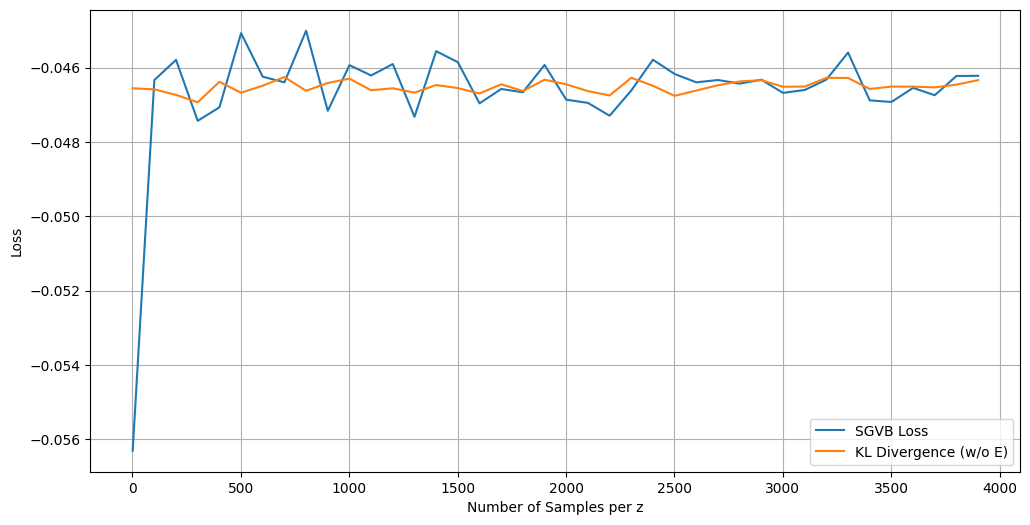

In [8]:
### Problem 2(d): Check if the analytical KL divergence matches the Monte Carlo estimate.
hidden_dims = [128, 32, 16, 4]
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
vae_test = VAE(input_dim, hidden_dims).to(device)

all_l_sgvb, all_KL_wo_E = [], []
all_n_samples_per_z = list(range(1, 4000, 100))

with torch.no_grad():
    for n_samples_per_z in all_n_samples_per_z:
        for _, (imgs, _) in enumerate(MNIST_loader):
            batch_size = imgs.shape[0]
            imgs = imgs.reshape(batch_size, -1).to(device)

            output = vae_test(imgs, n_samples_per_z=n_samples_per_z)

            l_sgvb = torch.mean(loss_SGVB(output))
            l_KL_wo_E = torch.mean(loss_KL_wo_E(output))

            all_l_sgvb.append(l_sgvb.item())
            all_KL_wo_E.append(l_KL_wo_E.item())
            break

# Plot the two curves
plt.figure(figsize=(12, 6))

plt.plot(all_n_samples_per_z, all_l_sgvb, label='SGVB Loss')
plt.plot(all_n_samples_per_z, all_KL_wo_E, label='KL Divergence (w/o E)')

plt.xlabel('Number of Samples per z')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

##### Hyperparameter settings

In [9]:
# epochs = 20
# hidden_dims = [128, 32, 16, 4]
# lr = 1e-4
# weight_decay = 1e-8
# coeff = 1e-3

epochs = 90
hidden_dims = [384, 192, 4]
lr = 8e-4
weight_decay = 0.0
coeff = 1.0e-3

assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

##### Training with SGVB loss

input_dim:  784
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=384, bias=True)
    (1): ReLU()
    (2): Linear(in_features=384, out_features=192, bias=True)
    (3): ReLU()
    (4): Linear(in_features=192, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=192, bias=True)
    (3): ReLU()
    (4): Linear(in_features=192, out_features=384, bias=True)
    (5): ReLU()
    (6): Linear(in_features=384, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


Epochs:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/90], Average Loss: 0.0264



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/90], Average Loss: 0.0216



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/90], Average Loss: 0.0205



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/90], Average Loss: 0.0198



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/90], Average Loss: 0.0192



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/90], Average Loss: 0.0187



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/90], Average Loss: 0.0184



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/90], Average Loss: 0.0181



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/90], Average Loss: 0.0179



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/90], Average Loss: 0.0177



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/90], Average Loss: 0.0175



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/90], Average Loss: 0.0174



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/90], Average Loss: 0.0172



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/90], Average Loss: 0.0172



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/90], Average Loss: 0.0170



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/90], Average Loss: 0.0169



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/90], Average Loss: 0.0169



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/90], Average Loss: 0.0168



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/90], Average Loss: 0.0167



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/90], Average Loss: 0.0166



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [21/90], Average Loss: 0.0166



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [22/90], Average Loss: 0.0165



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [23/90], Average Loss: 0.0165



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [24/90], Average Loss: 0.0164



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [25/90], Average Loss: 0.0164



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [26/90], Average Loss: 0.0163



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [27/90], Average Loss: 0.0163



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [28/90], Average Loss: 0.0163



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [29/90], Average Loss: 0.0162



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [30/90], Average Loss: 0.0162



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [31/90], Average Loss: 0.0162



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [32/90], Average Loss: 0.0161



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [33/90], Average Loss: 0.0161



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [34/90], Average Loss: 0.0161



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [35/90], Average Loss: 0.0161



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [36/90], Average Loss: 0.0161



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [37/90], Average Loss: 0.0160



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [38/90], Average Loss: 0.0160



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [39/90], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [40/90], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [41/90], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [42/90], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [43/90], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [44/90], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [45/90], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [46/90], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [47/90], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [48/90], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [49/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [50/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [51/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [52/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [53/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [54/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [55/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [56/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [57/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [58/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [59/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [60/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [61/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [62/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [63/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [64/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [65/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [66/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [67/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [68/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [69/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [70/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [71/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [72/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [73/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [74/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [75/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [76/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [77/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [78/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [79/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [80/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [81/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [82/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [83/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [84/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [85/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [86/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [87/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [88/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [89/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [90/90], Average Loss: 0.0153



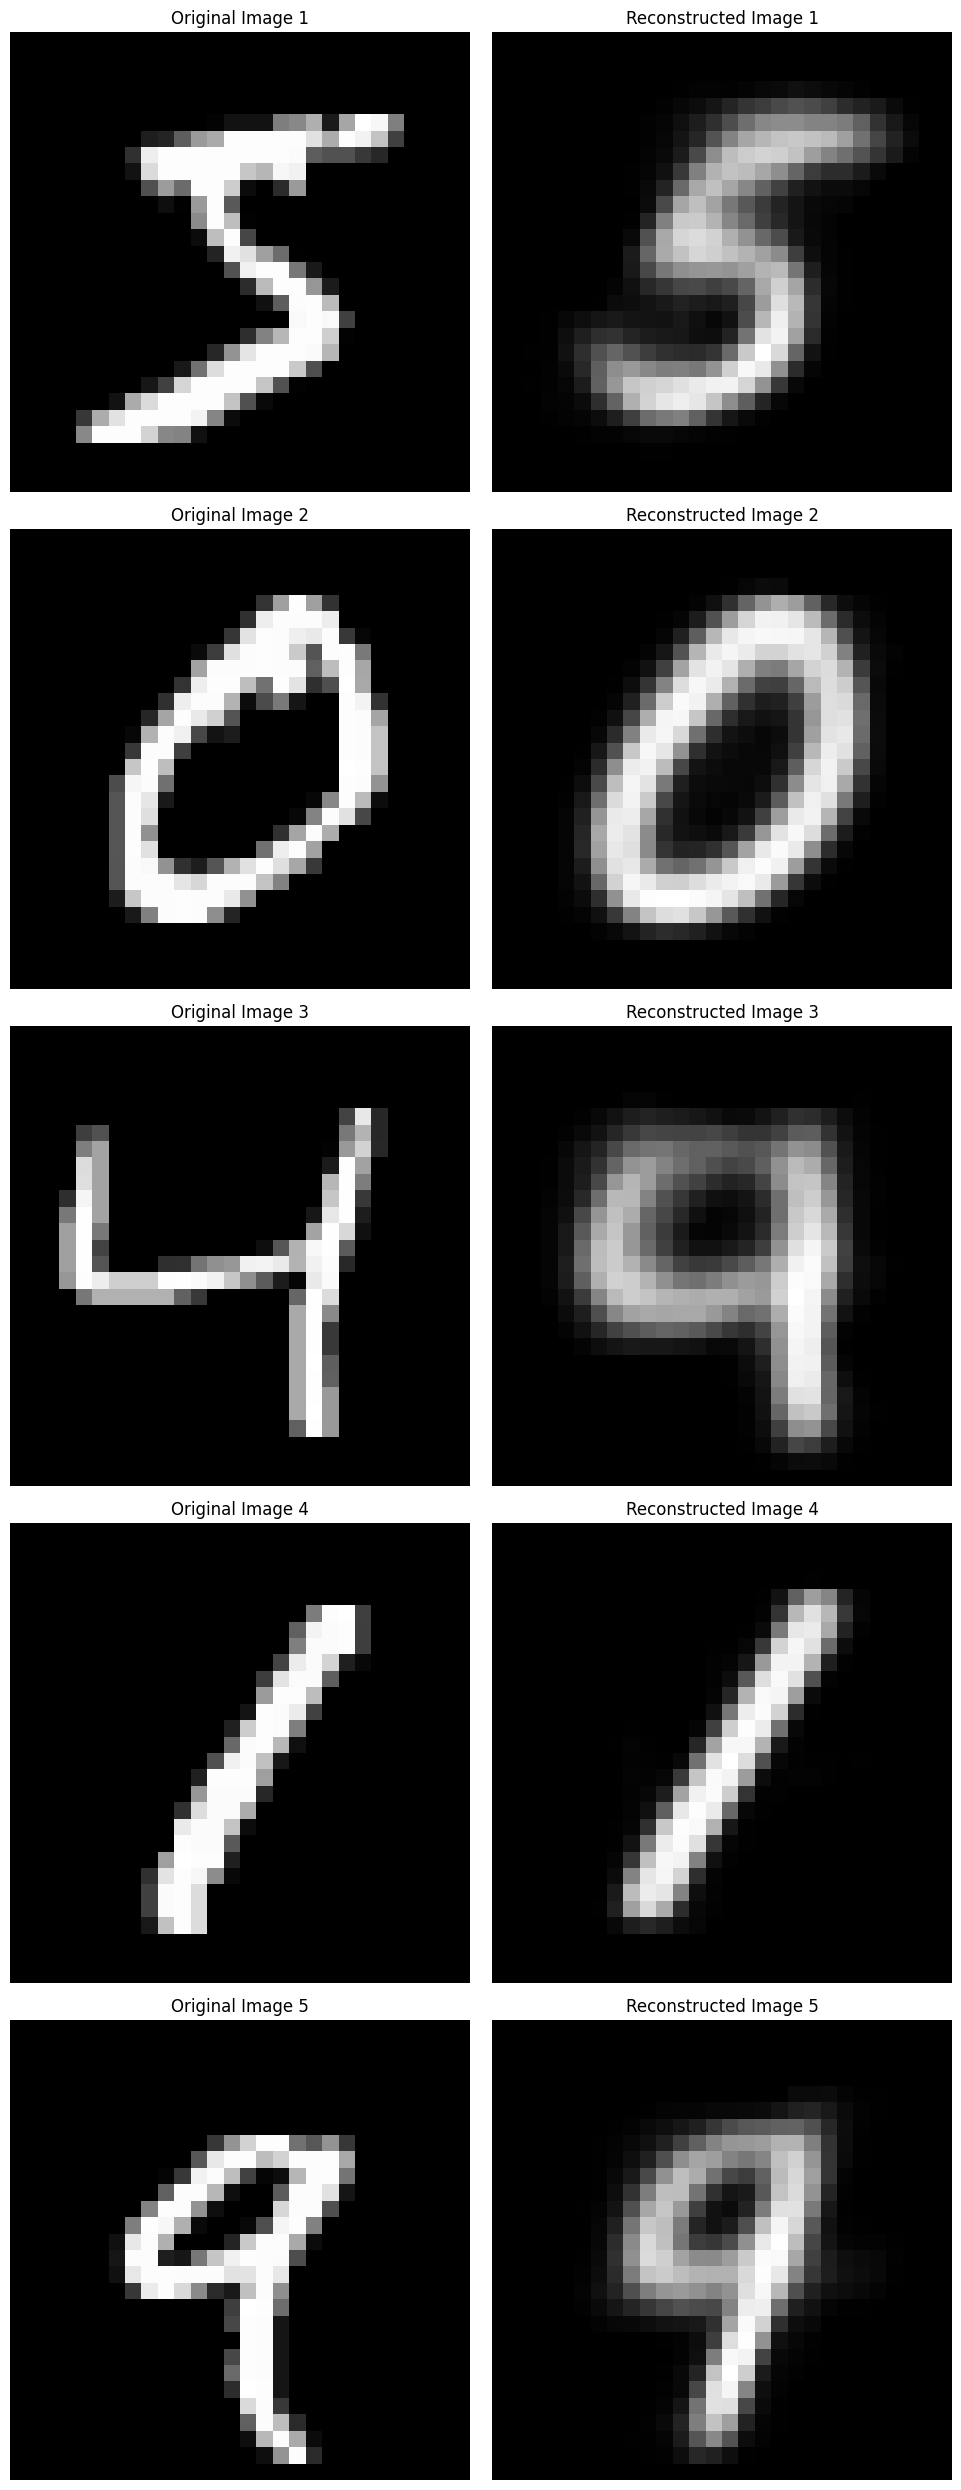

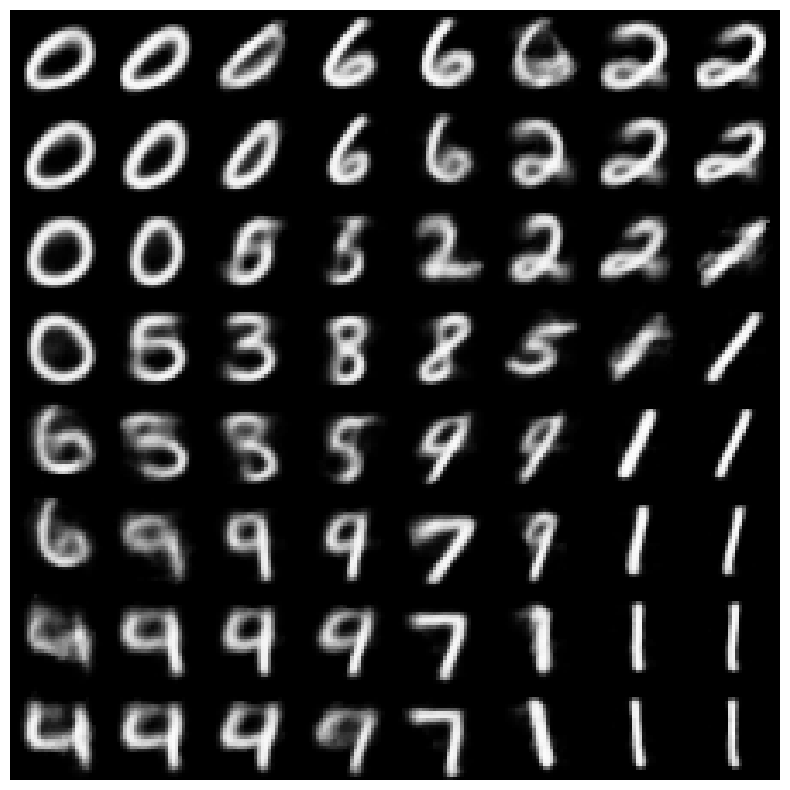

In [10]:
### Problem 2(e): Train VAE with SGVB loss
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_sgvb = VAE(input_dim, hidden_dims).to(device)
print(vae_sgvb)

optimizer_vae_sgvb = torch.optim.Adam(vae_sgvb.parameters(), lr=lr, weight_decay=weight_decay)

log_vae_sgvb = train(MNIST_loader, vae_sgvb, lambda model, x: loss_func(model, x, reg_func=loss_SGVB, coeff=coeff), optimizer_vae_sgvb, epochs)

### Evalutaion
eval(vae_sgvb)
plot_latent_images(vae_sgvb, n=8)

##### Trainimg with analytical KL

input_dim:  784
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=384, bias=True)
    (1): ReLU()
    (2): Linear(in_features=384, out_features=192, bias=True)
    (3): ReLU()
    (4): Linear(in_features=192, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=192, bias=True)
    (3): ReLU()
    (4): Linear(in_features=192, out_features=384, bias=True)
    (5): ReLU()
    (6): Linear(in_features=384, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


Epochs:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/90], Average Loss: 0.0271



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/90], Average Loss: 0.0218



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/90], Average Loss: 0.0204



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/90], Average Loss: 0.0196



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/90], Average Loss: 0.0191



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/90], Average Loss: 0.0187



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/90], Average Loss: 0.0183



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/90], Average Loss: 0.0180



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/90], Average Loss: 0.0178



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/90], Average Loss: 0.0176



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/90], Average Loss: 0.0174



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/90], Average Loss: 0.0173



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/90], Average Loss: 0.0171



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/90], Average Loss: 0.0170



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/90], Average Loss: 0.0169



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/90], Average Loss: 0.0168



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/90], Average Loss: 0.0167



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/90], Average Loss: 0.0166



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/90], Average Loss: 0.0165



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/90], Average Loss: 0.0165



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [21/90], Average Loss: 0.0164



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [22/90], Average Loss: 0.0163



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [23/90], Average Loss: 0.0163



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [24/90], Average Loss: 0.0162



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [25/90], Average Loss: 0.0162



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [26/90], Average Loss: 0.0161



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [27/90], Average Loss: 0.0161



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [28/90], Average Loss: 0.0160



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [29/90], Average Loss: 0.0160



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [30/90], Average Loss: 0.0160



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [31/90], Average Loss: 0.0160



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [32/90], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [33/90], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [34/90], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [35/90], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [36/90], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [37/90], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [38/90], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [39/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [40/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [41/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [42/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [43/90], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [44/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [45/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [46/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [47/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [48/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [49/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [50/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [51/90], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [52/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [53/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [54/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [55/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [56/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [57/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [58/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [59/90], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [60/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [61/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [62/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [63/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [64/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [65/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [66/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [67/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [68/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [69/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [70/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [71/90], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [72/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [73/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [74/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [75/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [76/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [77/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [78/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [79/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [80/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [81/90], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [82/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [83/90], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [84/90], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [85/90], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [86/90], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [87/90], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [88/90], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [89/90], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [90/90], Average Loss: 0.0152



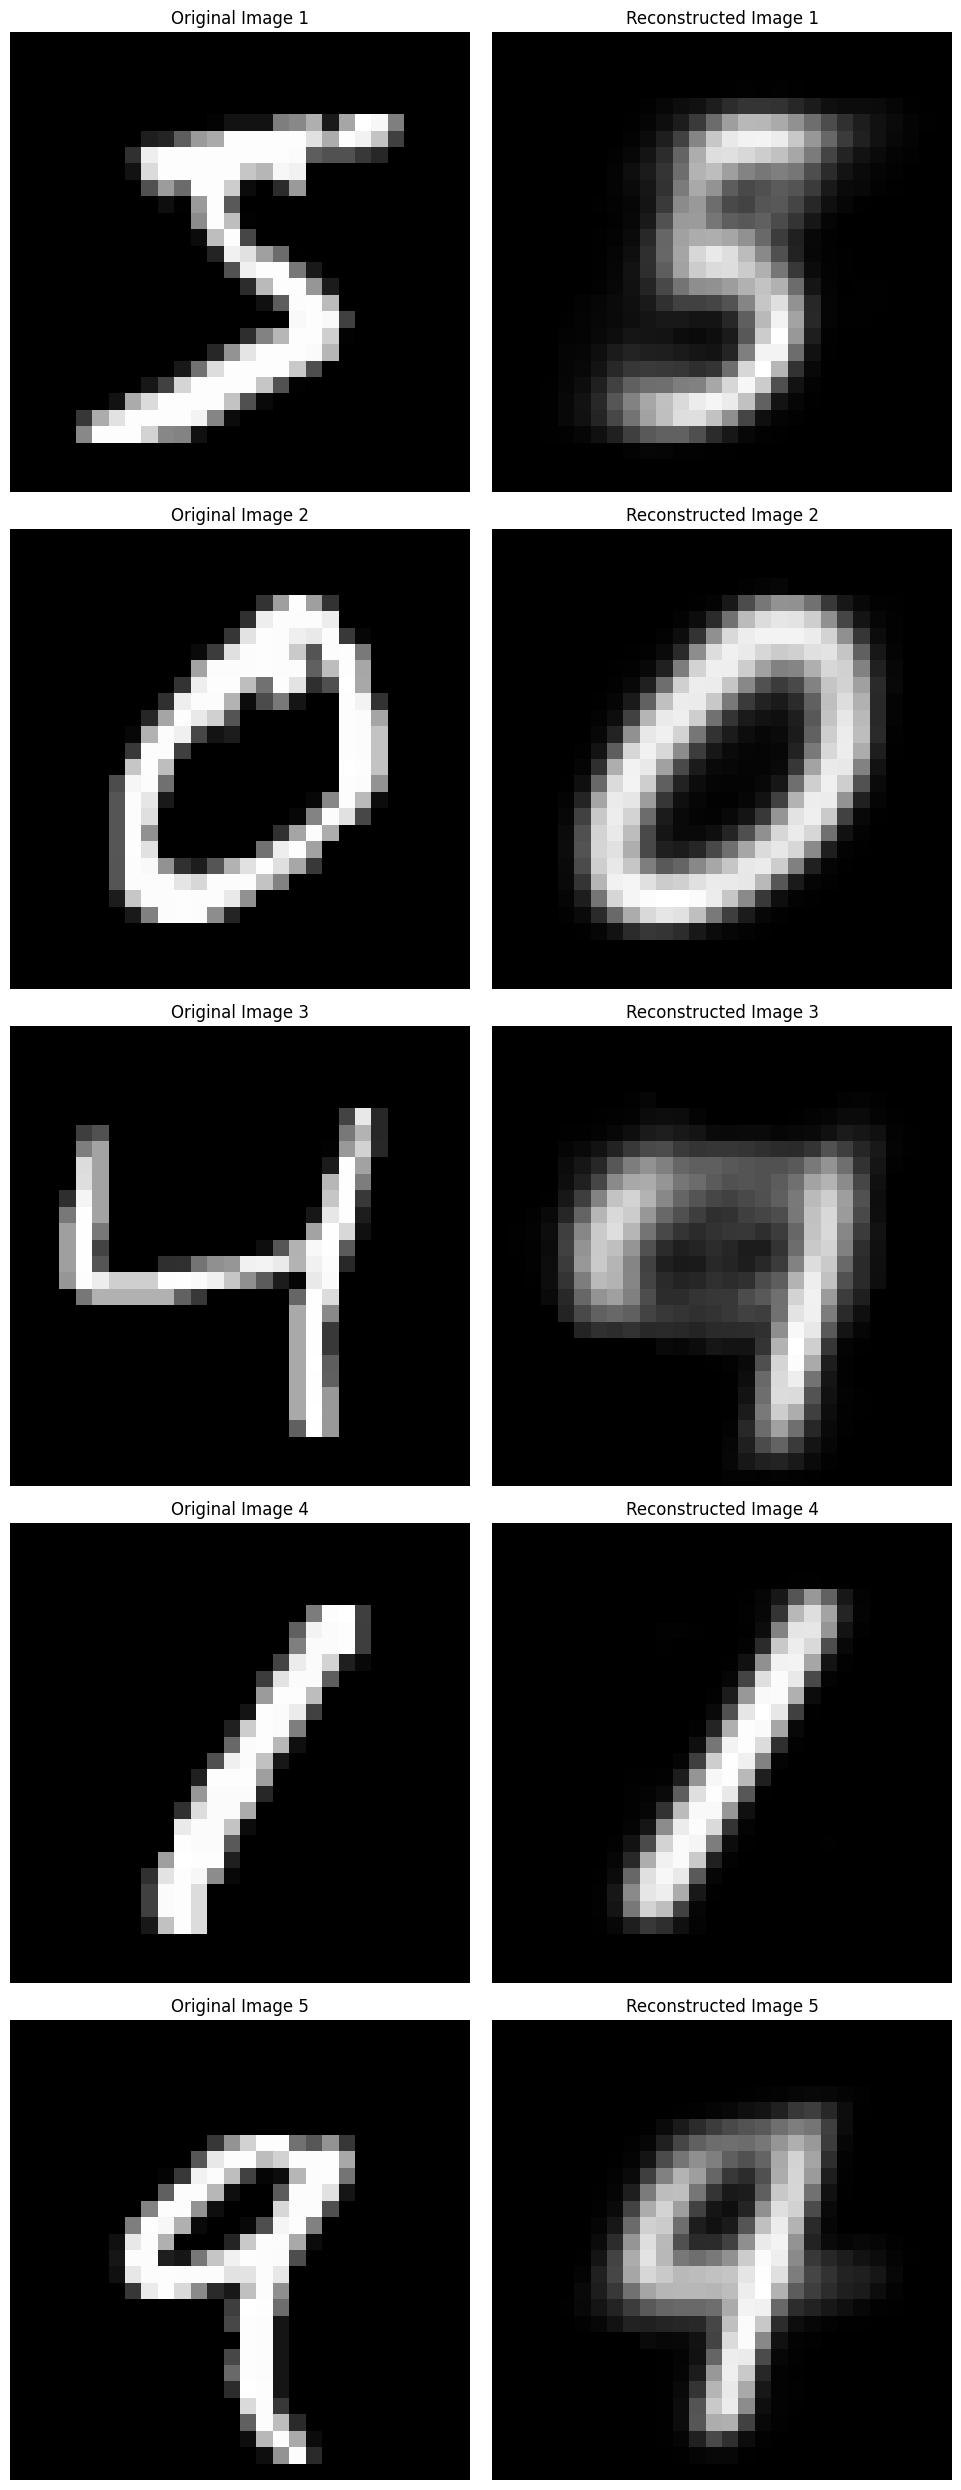

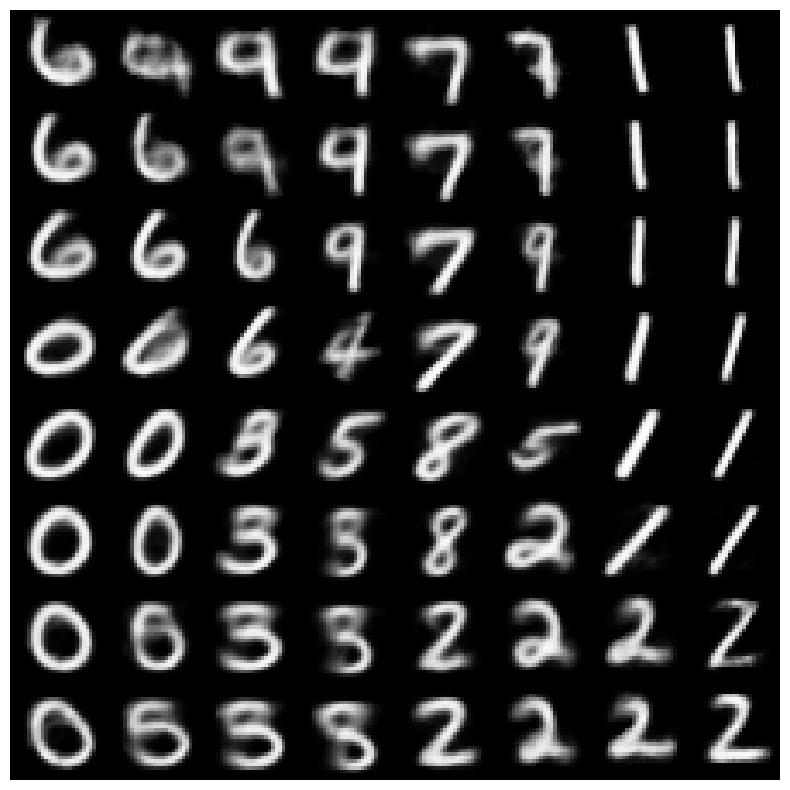

In [11]:
### Problem 2(e): Train VAE with analytical KL
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_kl_wo_e = VAE(input_dim, hidden_dims).to(device)
print(vae_kl_wo_e)

optimizer_vae_kl_wo_e = torch.optim.Adam(vae_kl_wo_e.parameters(), lr=lr, weight_decay=weight_decay)

log_vae_kl_wo_e = train(MNIST_loader, vae_kl_wo_e, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=coeff), optimizer_vae_kl_wo_e, epochs)


### Evaluation
eval(vae_kl_wo_e)
plot_latent_images(vae_kl_wo_e, n=8)